**Students names :** TO BE COMPLETED

# Lab 4 : Steganography

This multimedia tutorial is done in Python3, using the scikit-image library. The arrays used by this library to manipulate the images (ndarray) come from the numpy library. The documentation of these two libraries will be very useful.

**Note:** All the scripts in this tutorial work by default on an example image (Lenna), but you can experiment with other images to test the algorithms in various situations.


## Steganography ?

Steganography or image watermarking is a set of techniques to hide information in an image (the secret). In this tutorial we will hide text and images in images. But it is of course possible to hide any binary data.


## Steganography in the spatial domain

In this first part we will focus on a simple steganography technique operating directly on pixel values. The script below provides a simple implementation of this technique.


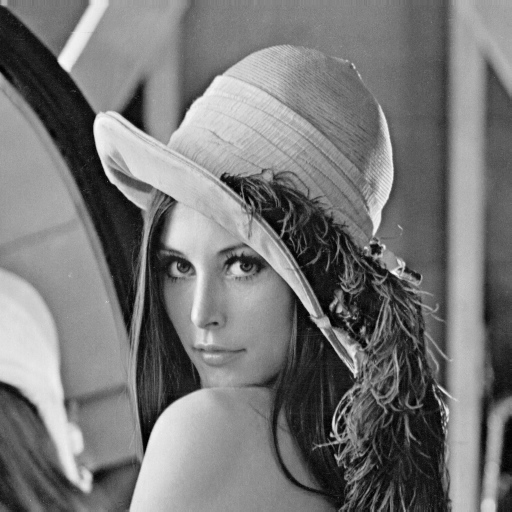

Taille du secret (nb d'octets) : 89926



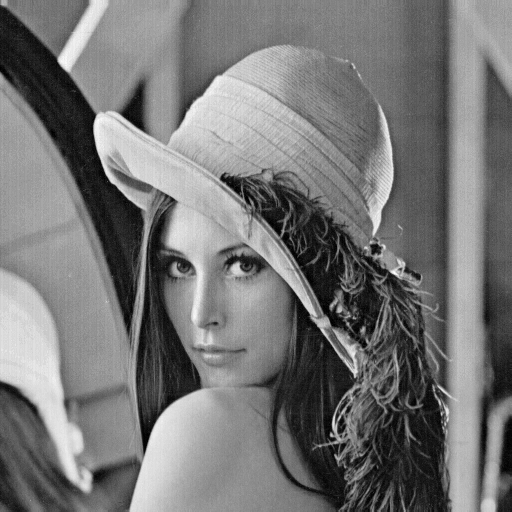


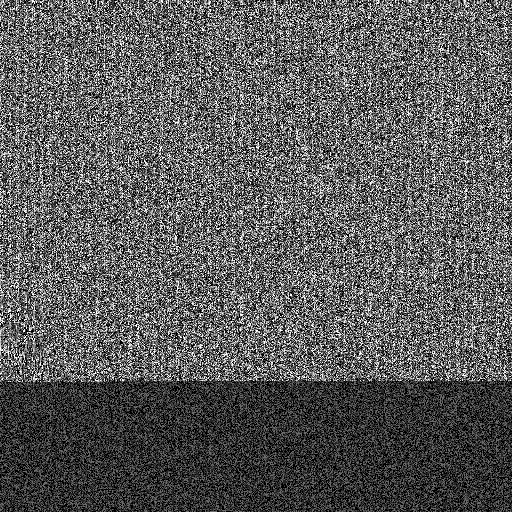

Taille de l'image (nb d'octets) : 262144
64 premiers octets (originale):  [1111011 10011011 10101010 10101110 10101101 10101011 10100101 10001010
 1110111 1110100 1101101 1110010 1110001 1101011 1110101 1101100 1110110
 1110011 1111011 1111001 1111000 1111101 1110100 1111001 1111000 1110111
 1111110 1111010 1111000 1111001 1110100 1111101 1101111 1110000 1110110
 1110111 1110111 1110110 1111101 1111011 1111000 1110110 1111011 1110111
 1110001 1111110 1110101 1110101 1111000 1110010 1110100 1110110 1110010
 1110110 1110101 1110101 1110001 1110011 1110100 1110011 1111011 1110110
 1110101 1110101]
64 premiers octets (steganographiée):  [1111000 10011110 10101110 10101000 10101110 10101000 10100000 10001100
 1110000 1110110 1101110 1110000 1110000 1101010 1110000 1101110 1110000
 1110110 1111110 1111000 1111110 1111110 1110010 1111100 1111000 1110010
 1111110 1111000 1111000 1111010 1110000 1111000 1101000 1110110 1110110
 1110010 1110100 1110100 1111010 1111000 1111000 1110110 1111110 111

Secret :  Lorem ipsum dolor sit amet, consectetur adipiscing elit. Phasellus feugiat massa ut dolor tincidunt vestibulum. Aenean vehicula pulvinar est, non consectetur mi. Sed sagittis eu sem in consequat. Aliquam erat volutpat. Proin posuere dui nec auctor congue.  [...]


In [2]:
from skimage import io
from skimage import metrics
import numpy as np
import plotly.express as px

# To ease matrices display later in this lab
np.set_printoptions(suppress=True)
np.set_printoptions(precision=0)
np.set_printoptions(threshold=1000)

'''
SteganographyException
'''
class SteganographyException(Exception):
    pass

'''
Class for LSB based steganography
'''
class SpaceSteg():
    def __init__(self, im):
        self.image = im
        self.width = im.shape[1]
        self.height = im.shape[0]
        self.size = self.width * self.height
        if len(im.shape) == 2:
            self.nbchannels = 1
            self.image = self.image.reshape((self.height,self.width,self.nbchannels))
        else:
            self.nbchannels = im.shape[2]
    
        self.maskONEValues = [1,2,4,8,16,32,64,128]
        #Mask used to put one ex:1->00000001, 2->00000010 .. associated with OR bitwise
        self.maskONE = self.maskONEValues.pop(0) #Will be used to do bitwise operations

        self.maskZEROValues = [254,253,251,247,239,223,191,127]
        #Mak used to put zero ex:254->11111110, 253->11111101 .. associated with AND bitwise
        self.maskZERO = self.maskZEROValues.pop(0)
        
        self.curwidth = 0 #Current width position
        self.curheight = 0 #Current height position
        self.curchan = 0 #Current channel position

    def getImage(self):
    # Save the image using the given filename
        if self.nbchannels == 1:
            return self.image.reshape((self.height, self.width))
        else:
            return self.image.reshape((self.height, self.width, self.nbchannels))


    def putBinaryValue(self, bits): #Put the bits in the image
        for c in bits:
            val = self.image[self.curheight,self.curwidth, self.curchan]
            if int(c) == 1:
                val = int(val) | self.maskONE #OR with maskONE
            else:
                val = int(val) & self.maskZERO #AND with maskZERO

            self.image[self.curheight,self.curwidth, self.curchan] = val
            self.nextSpace() #Move "cursor" to the next space
            
    def nextSpace(self):#Move to the next slot were information can be taken or put
        if self.curchan == self.nbchannels-1: #Next Space is the following channel
            self.curchan = 0
            if self.curwidth == self.width-1: #Or the first channel of the next pixel of the same line
                self.curwidth = 0
                if self.curheight == self.height-1:#Or the first channel of the first pixel of the next line
                    self.curheight = 0
                    if self.maskONE == 128: #Mask 1000000, so the last mask
                        raise SteganographyException("Image filled")
                    else: #Or instead of using the first bit start using the second and so on..
                        self.maskONE = self.maskONEValues.pop(0)
                        self.maskZERO = self.maskZEROValues.pop(0)
                else:
                    self.curheight +=1
            else:
                self.curwidth +=1
        else:
            self.curchan +=1  

    def readBit(self): #Read a single bit int the image
        val = self.image[self.curheight,self.curwidth, self.curchan]
        val = int(val) & self.maskONE
        self.nextSpace()
        if val > 0:
            return "1"
        else:
            return "0"

    def readByte(self):
        return self.readBits(8)

    def readBits(self, nb): #Read the given number of bits
        bits = ""
        for i in range(nb):
            bits += self.readBit()
        return bits

    def byteValue(self, val):
        return self.binValue(val, 8)

    def binValue(self, val, bitsize): #Return the binary value of an int as a byte
        binval = bin(val)[2:]
        if len(binval) > bitsize:
            raise SteganographyException("binary value larger than the expected size")
        while len(binval) < bitsize:
            binval = "0"+binval
        return binval

    def hideBin(self, filename):
        f = open(filename,'rb')
        bin = f.read()
        l = len(bin)
        print("Secret size (numer of bytes) :", l)
        if self.width*self.height*self.nbchannels < l+64:
            raise SteganographyException("Carrier image not big enough to hold all the datas to steganography")
        self.putBinaryValue(self.binValue(l, 64))
        for byte in bin:
            self.putBinaryValue(self.byteValue(byte))

    def unhideBin(self):
        l = int(self.readBits(64),2)
        output = ""
        for i in range(l):
            output += chr(int(self.readByte(),2))
        return output


    
'''    
Main program
'''
sourceimage = "lena.jpg"
secretfile = "secret-maxi.txt"

# Insert the secret into the image
carrier = io.imread(sourceimage)
fig = px.imshow(carrier, binary_string=True)
fig.update_layout( title_text="Original image", title_x=0.5)
fig.show()

steg = SpaceSteg(carrier)
steg.hideBin(secretfile)
hidden = steg.getImage()
fig = px.imshow(hidden, binary_string=True)
fig.update_layout( title_text="Image after steganography", title_x=0.5)
fig.show()

# Display useful information
carrier = io.imread(sourceimage)
diff = abs(carrier.astype(int)-hidden.astype(int))
fig = px.imshow(diff, binary_string=True)
fig.update_layout( title_text="Absolute value of the byte to byte difference between the two images", title_x=0.5)
fig.show()
print("Images size (number of bytes) :", carrier.size)
np.set_printoptions(formatter={'int':lambda x:"{0:b}".format(int(x))})
print("64 first bytes (original): ",carrier[0,0:64].astype(int))
print("64 first bytes (steganography): ",hidden[0,0:64].astype(int))
np.set_printoptions(formatter=None)
print("Differences in the 64 fist bytes : ",carrier[0,0:64].astype(int)-hidden[0,0:64].astype(int))
print("Differentes after byte 64 (1st line) : ",carrier[0,64:].astype(int)-hidden[0,64:].astype(int))
print("Max difference : ",diff.max())
print("PSNR : ",metrics.peak_signal_noise_ratio(carrier,hidden))

# Retrieve the secret
steg = SpaceSteg(hidden)
binsecret = steg.unhideBin()
if len(binsecret) > 256:
    print("Secret : ", binsecret[0:256], "[...]") # we only print the beginning of the secret
else:
    print("Secret : ", binsecret)
    


**Question 1:** Test the algorithm with "secret-nano.txt", "secret-mini.txt", "secret.txt" and "secret-maxi.txt". Based on the results displayed (and looking at the code if necessary), explain how the algorithm works.

**Answer 1:** 

**Question 2:** By varying the size of the secret and looking at the PSNR values obtained (as well as your own judgment), determine the maximum capacity of this algorithm that allows to keep an acceptable image quality.

**Answer 2:**

**Question 3:** Based on your understanding of the algorithm used:
1. How easy is it to detect that an image has been steganographed? Explain.
2. If it is possible can we easily recover the information hidden in the image? Explain.
3. How could the privacy of the hidden data be improved?

**Answer 3:** 

**Question 4:** Test some simple transformations on the steganographed image. 
1. Is this algorithm robust to transformations?
2. Is there a simple way to improve it?

In [3]:
from skimage import transform

ratio=0.95
# Here we just adjust the scale of the image but you can try other trnasformations (rotation, blur, JPEG compression, etc.)
smaller = transform.resize(hidden, ( int(carrier.shape[0]*ratio), int(carrier.shape[1]*ratio)))
steg = SpaceSteg(smaller)
binsecret = steg.unhideBin()
print(binsecret) # If nothing is displayed then we lost the secret

**Answer 4:**

## Steganography in the frequency domain

We will now try to apply (naively) the same technique as before, but to the DCT coefficients that could be obtained by compressing an image in JPEG format (as in the TP of the same name).

Coefficents du 1er bloc de l'image (originale): [[133. 116. 117. 127. 124. 128. 127. 128.]
 [158. 137. 123. 128. 126. 128. 128. 128.]
 [110. 124. 132. 128. 129. 128. 128. 128.]
 [134. 127. 126. 128. 128. 128. 128. 128.]
 [128. 131. 129. 128. 128. 128. 128. 128.]
 [127. 127. 128. 129. 128. 128. 128. 128.]
 [127. 128. 128. 128. 128. 128. 128. 128.]
 [129. 128. 128. 128. 128. 128. 128. 128.]]
Taille du secret (nb d'octets) : 29364


Coefficents du 1er bloc de l'image (stéganographiée): [[132. 116. 116. 126. 124. 128. 126. 128.]
 [158. 136. 123. 128. 126. 128. 128. 128.]
 [110. 125. 133. 128. 128. 129. 128. 129.]
 [134. 126. 127. 128. 128. 128. 128. 128.]
 [128. 131. 129. 128. 128. 128. 129. 129.]
 [126. 127. 129. 128. 128. 129. 128. 129.]
 [126. 129. 129. 128. 129. 128. 128. 129.]
 [128. 128. 129. 128. 128. 128. 128. 128.]]



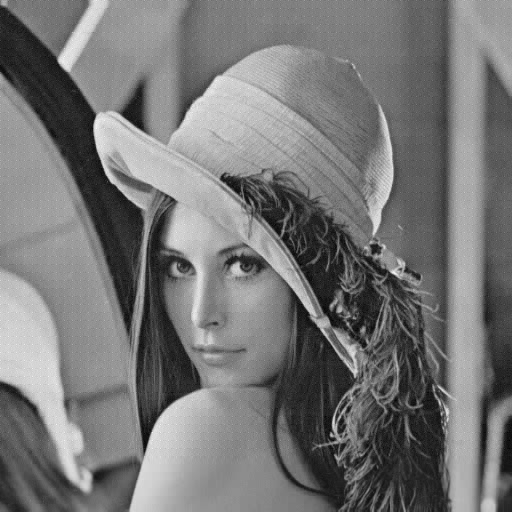

Secret :  Lorem ipsum dolor sit amet, consectetur adipiscing elit. Phasellus feugiat massa ut dolor tincidunt vestibulum. Aenean vehicula pulvinar est, non consectetur mi. Sed sagittis eu sem in consequat. Aliquam erat volutpat. Proin posuere dui nec auctor congue.  [...]
PSNR :  32.22979538524159


In [4]:
from skimage import transform
from skimage import color
import numpy as np
from scipy import fftpack

sourceimage = "lena.jpg"
secretfile = "secret.txt"

#Just in case...
#zigzagorder = [ 1,  9,  2,  3,  10, 17, 25, 18, 11, 4,  5,  12, 19, 26, 33, 41, 34, 27, 20, 13, 6,  7,  14, 21, 28, 35, 42, 49, 57, 50, 43, 36, 29, 22, 15, 8,  16, 23, 30, 37, 44, 51, 58, 59, 52, 45, 38, 31, 24, 32, 39, 46, 53, 60, 61, 54, 47, 40, 48, 55, 62, 63, 56, 64]

# read the source image
image = io.imread(sourceimage)

# resize it to multiples of 8
image = transform.resize(image,(image.shape[0]//8*8,image.shape[1]//8*8))
width=image.shape[1]
height=image.shape[0]

# process the DCT coefficient of the 8x8 blocks
greyimg=image #color.rgb2gray(image)
dctimg=np.zeros(greyimg.shape)

for y in range(0,height,8):
    for x in range(0, width,8):
        bloc=greyimg[y:y+8,x:x+8]
        dctimg[y:y+8,x:x+8]=128+(32*fftpack.dct(fftpack.dct(bloc,norm='ortho').T,norm='ortho').T).astype(int)
        dctimg[y,x] = (dctimg[y,x]-128)

# Stéganography       
print("Coefficents of the first image block (original image):",dctimg[0:8,0:8])
steg = SpaceSteg(dctimg)
steg.hideBin(secretfile)
print("Coefficents of the first image block (steganography):",dctimg[0:8,0:8])

# reconstruction (we decompress)
compressedimg=np.zeros(greyimg.shape)

for y in range(0,height,8):
    for x in range(0, width,8):
        bloc=dctimg[y:y+8,x:x+8]-128
        bloc[0,0] = (bloc[0,0]+128)
        compressedimg[y:y+8,x:x+8]=fftpack.idct(fftpack.idct(bloc/32,norm='ortho').T,norm='ortho').T

fig = px.imshow(compressedimg, binary_string=True)
fig.update_layout( title_text="Reconstruction", title_x=0.5)
fig.show()

# secret extraction
steg = SpaceSteg(dctimg)
binsecret = steg.unhideBin()
if len(binsecret) > 256:
    print("Secret : ", binsecret[0:256], "[...]") # we only display the beginning of the secret
else:
    print("Secret : ", binsecret)

print("PSNR : ",metrics.peak_signal_noise_ratio(greyimg,compressedimg))


**Question 5:** Test the algorithm with different secret sizes.
1. Is the quality obtained after DCT -> steganography -> inverse DCT satisfactory? Explain
2. What should be done to make the watermarking less obvious?
3. Will the storage capacity (of a secret) of the algorithm be different? Explain
4. In your opinion, is this frequency domain watermarking more robust to different transformations? Explain and test if possible.

**Answer 5**:

**Bonus question:** Modify the `nextSpace` function and/or the above script to make the frequency domain watermarking less obvious.

In [5]:
# Write your modified code here

*Credits: part of the source code of this tutorial is inspired by the following code: https://github.com/RobinDavid/LSB-Steganography*